In [2]:
# ======================
# Preprocesamiento de datos para el dataset 'startup-success-prediction'
# ======================

!pip install kagglehub --quiet

import os
import pandas as pd
import numpy as np
import kagglehub
from sklearn.preprocessing import StandardScaler

# ======================
# 1. Descarga y carga del dataset original
# ======================
path = kagglehub.dataset_download("manishkc06/startup-success-prediction")
csv_path = os.path.join(path, "startup data.csv")
df = pd.read_csv(csv_path)

# ======================
# 2. Limpieza inicial de columnas irrelevantes
# ======================
initial_drop = [
    'Unnamed: 0', 'Unnamed: 6', 'state_code.1', 'id', 'object_id', 'name'
]
df.drop(columns=[c for c in initial_drop if c in df.columns], inplace=True)

# ======================
# 3. Conversión de columnas de fecha
# ======================
for c in ['founded_at', 'closed_at', 'first_funding_at', 'last_funding_at']:
    df[c] = pd.to_datetime(df[c], errors='coerce')

# ======================
# 4. Asegurar existencia de la columna 'status'
# ======================
if 'status' not in df.columns:
    raw = pd.read_csv(csv_path, usecols=['status'])
    df['status'] = raw['status']

# ======================
# 5. Creación de variables temporales derivadas
# ======================
fecha_corte = pd.to_datetime("2025-01-01")
df['lifetime_years'] = ((df['closed_at'].fillna(fecha_corte) - df['founded_at']).dt.days / 365).round(2)
df['funding_delay_years'] = ((df['first_funding_at'] - df['founded_at']).dt.days / 365).round(2)
df['last_milestone_delay_years'] = ((df['last_funding_at'] - df['founded_at']).dt.days / 365).round(2)
df['post_funding_duration_years'] = ((df['closed_at'].fillna(fecha_corte) - df['last_funding_at']).dt.days / 365).round(2)

# ======================
# 6. Eliminación de observaciones con errores temporales
# ======================
mask = (
    (df['lifetime_years'] < 0) |
    (df['funding_delay_years'] < 0) |
    (df['last_milestone_delay_years'] < 0) |
    (df['post_funding_duration_years'] < 0) |
    (df.get('age_first_funding_year', 0) < 0) |
    (df.get('age_last_funding_year', 0) < 0) |
    (df.get('age_first_milestone_year', 0) < 0) |
    (df.get('age_last_milestone_year', 0) < 0)
)
df = df.loc[~mask].copy()

# ======================
# 7. Clasificación sector y agrupación de ciudades
# ======================
tech = {'software', 'web', 'mobile', 'enterprise'}
df['main_sector'] = df['category_code'].apply(lambda x: 'tech' if x in tech else 'non_tech')

top = df['city'].value_counts()
freq = top[top > 20].index
df['city_grouped'] = df['city'].apply(lambda x: x if x in freq else 'other')

# ======================
# 8. Escalado de variables numéricas
# ======================
scaler = StandardScaler()
for col in ['funding_total_usd', 'relationships', 'avg_participants']:
    if col in df.columns:
        df[f"{col}_scaled"] = scaler.fit_transform(df[[col]])

# ======================
# 9. Variables booleanas derivadas
# ======================
df['has_milestones'] = df['milestones'] > 0
df['has_late_funding'] = (df.get('has_roundC', 0) == 1) | (df.get('has_roundD', 0) == 1)

# ======================
# 10. Eliminación de columnas redundantes
# ======================
derived_drop = [
    'city', 'category_code', 'founded_at', 'closed_at', 'first_funding_at', 'last_funding_at',
    'milestones', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD',
    'funding_total_usd', 'relationships', 'avg_participants'
]

extra_drop = [
    'age_first_funding_year', 'age_last_funding_year',
    'age_first_milestone_year', 'age_last_milestone_year',
    'state_code', 'zip_code', 'latitude', 'longitude',
    'has_milestone_info', 'status', 'is_top500'
]

drop_all = derived_drop + extra_drop + [c for c in df.columns if c.startswith('is_')]
df.drop(columns=[c for c in drop_all if c in df.columns], inplace=True)

# ======================
# 11. Separación de variable objetivo
# ======================
X = df.drop(columns='labels')
y = df['labels'].astype(int).values

# ======================
# 12. Resultado final
# ======================
print("Columnas finales disponibles para modelado:", X.columns.tolist())
print("Número de muestras:", X.shape[0])

100%|██████████| 64.1k/64.1k [00:00<00:00, 40.8MB/s]

Extracting files...
Columnas finales disponibles para modelado: ['funding_rounds', 'has_VC', 'has_angel', 'lifetime_years', 'funding_delay_years', 'last_milestone_delay_years', 'post_funding_duration_years', 'main_sector', 'city_grouped', 'funding_total_usd_scaled', 'relationships_scaled', 'avg_participants_scaled', 'has_milestones', 'has_late_funding']
Número de muestras: 825


Fitting 5 folds for each of 6 candidates, totalling 30 fits
mejores parámetros: {'svc__C': 0.1, 'svc__gamma': 'auto'}
accuracy en test: 0.9879
              precision    recall  f1-score   support

           0     0.9649    1.0000    0.9821        55
           1     1.0000    0.9818    0.9908       110

    accuracy                         0.9879       165
   macro avg     0.9825    0.9909    0.9865       165
weighted avg     0.9883    0.9879    0.9879       165



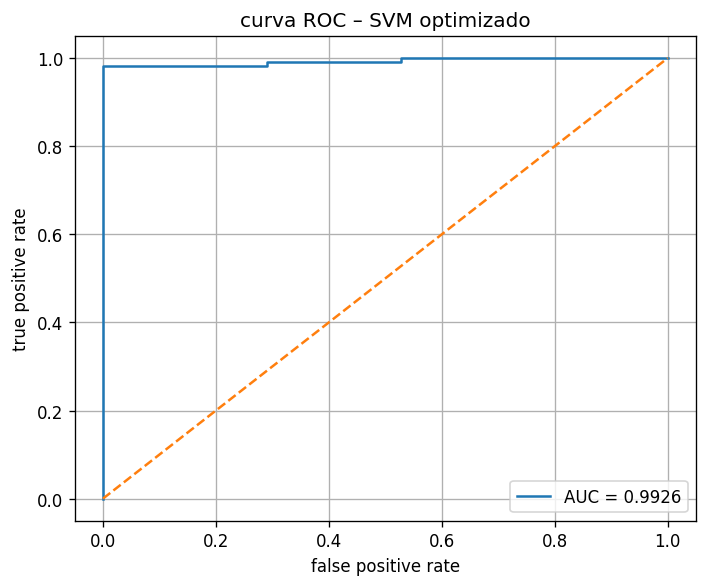

  0%|          | 0/50 [00:00<?, ?it/s]

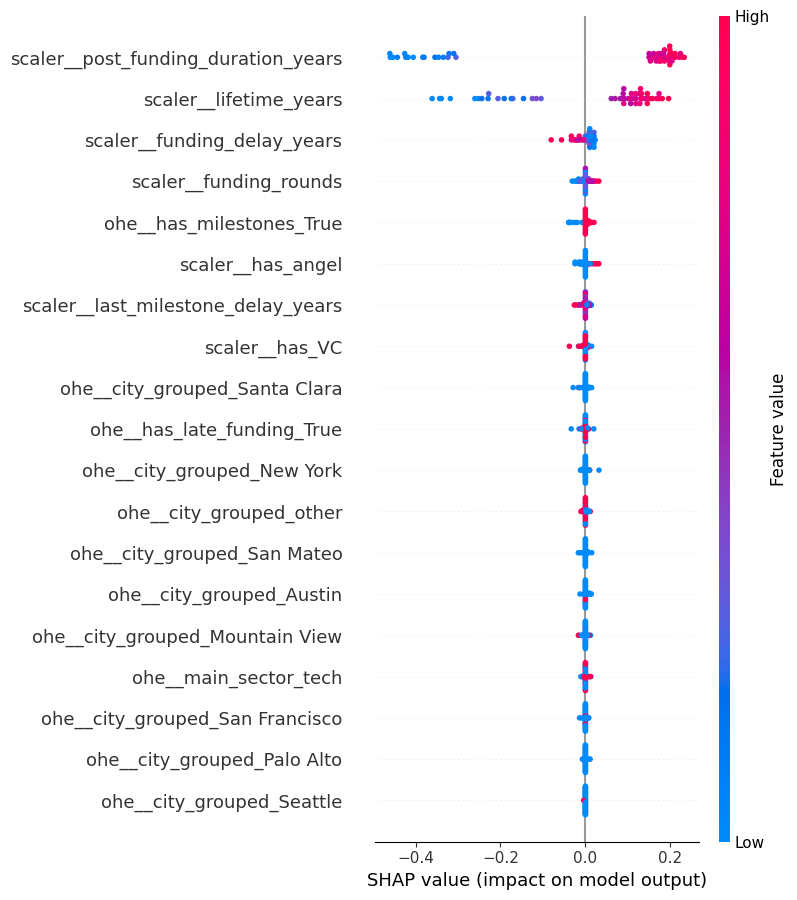

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import shap
import matplotlib.pyplot as plt

# ======================
# 1. división del dataset en train y test
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# ======================
# 2. detección de columnas categóricas y numéricas
# ======================
cat_cols = X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()
num_cols = [
    c for c in X.select_dtypes(include=['int64', 'float64']).columns
    if not c.endswith('_scaled')
]

# ======================
# 3. preprocesamiento: one-hot encoding y escalado
# ======================
preprocessor = ColumnTransformer([
    ('ohe',    OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary'), cat_cols),
    ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True),              num_cols)
], remainder='drop')

# ======================
# 4. pipeline completo con SVM probabilístico
# ======================
pipe = Pipeline([
    ('prep', preprocessor),
    ('svc',  SVC(kernel='rbf', probability=True))
])

# ======================
# 5. grid search con validación cruzada estratificada
# ======================
param_grid = {
    'svc__C':     [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# ======================
# 6. ajuste del modelo
# ======================
grid.fit(X_train, y_train)
print("mejores parámetros:", grid.best_params_)
best_model = grid.best_estimator_

# ======================
# 7. evaluación en el conjunto de test
# ======================
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print(f"accuracy en test: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, digits=4))

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5), dpi=120)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("curva ROC – SVM optimizado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ======================
# 8. explicación con SHAP usando KernelExplainer
# ======================
# 8.1 nombres de característica tras preprocesado
feature_names = best_model.named_steps['prep'].get_feature_names_out()

# 8.2 transformación de datos
X_train_t = best_model.named_steps['prep'].transform(X_train)
X_test_t  = best_model.named_steps['prep'].transform(X_test)

# 8.3 selección de subconjuntos para background y explicación
rng       = np.random.RandomState(42)
bg_idx    = rng.choice(X_train_t.shape[0], 100, replace=False)
exp_idx   = rng.choice(X_test_t.shape[0],  50, replace=False)
X_background = X_train_t[bg_idx]
X_explain    = X_test_t[exp_idx]

# 8.4 función de predicción sobre datos transformados
predict_fn = lambda data: best_model.named_steps['svc'].predict_proba(data)

# 8.5 inicialización de KernelExplainer
explainer = shap.KernelExplainer(predict_fn, X_background)

# 8.6 cálculo de valores SHAP para ambas clases con KernelExplainer
shap_values = explainer.shap_values(X_explain, nsamples=100)  # devuelve lista [valores_clase0, valores_clase1]

# 8.6.1 seleccionar los valores de SHAP para la clase positiva si existen
if not isinstance(shap_values, list) or len(shap_values) < 2:
    shap_values_for_expl = shap_values
else:
    shap_values_for_expl = shap_values[1]  # usar valores de la clase 1

# 8.7 construcción del objeto Explanation para la clase positiva
expl_pos = shap.Explanation(
    values       = shap_values_for_expl,
    base_values  = np.repeat(explainer.expected_value[1], X_explain.shape[0]),
    data         = X_explain,
    feature_names= feature_names
)

# 8.8 inicialización de la visualización JavaScript de SHAP
shap.initjs()

# 8.9 extraer valores SHAP en la dimensión correcta
if expl_pos.values.ndim == 3:
    shap_values_pos = expl_pos.values[:, :, 1]
else:
    shap_values_pos = expl_pos.values

# 8.10 adaptar la forma de los valores SHAP al shape de los datos
shap_values_pos = shap_values_pos.reshape(expl_pos.data.shape)

# 8.11 mostrar el summary plot sin desajustes de dimensiones
shap.summary_plot(shap_values_pos, expl_pos.data, feature_names=expl_pos.feature_names)

In [5]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62814 | val_accuracy: 0.47273 | val_auc: 0.4805  |  0:00:00s
epoch 1  | loss: 0.41506 | val_accuracy: 0.56364 | val_auc: 0.5243  |  0:00:00s
epoch 2  | loss: 0.19738 | val_accuracy: 0.69091 | val_auc: 0.78893 |  0:00:00s
epoch 3  | loss: 0.10382 | val_accuracy: 0.70909 | val_auc: 0.90504 |  0:00:00s
epoch 4  | loss: 0.10231 | val_accuracy: 0.74545 | val_auc: 0.93339 |  0:00:00s
epoch 5  | loss: 0.08568 | val_accuracy: 0.7697  | val_auc: 0.87818 |  0:00:00s
epoch 6  | loss: 0.04742 | val_accuracy: 0.8     | val_auc: 0.9062  |  0:00:01s
epoch 7  | loss: 0.04132 | val_accuracy: 0.83636 | val_auc: 0.94653 |  0:00:01s
epoch 8  | loss: 0.05142 | val_accuracy: 0.85455 | val_auc: 0.96926 |  0:00:01s
epoch 9  | loss: 0.03894 | val_accuracy: 0.92121 | val_auc: 0.9738  |  0:00:01s
epoch 10 | loss: 0.03926 | val_accuracy: 0.93333 | val_auc: 0.98562 |  0:00:01s
epoch 11 | loss: 0.0365  | val_accuracy: 0.93939 | val_auc: 0.99124 |  0:00:01s
epoch 12 | loss: 0.0327  | val_accuracy:

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


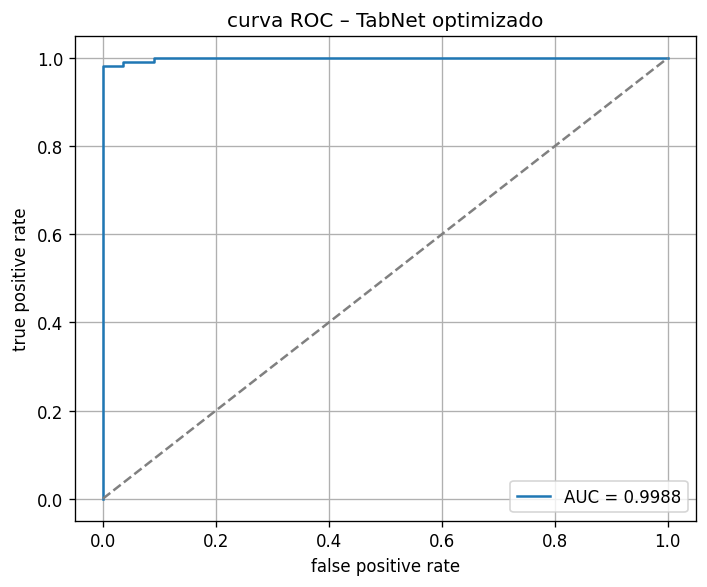

  0%|          | 0/20 [00:00<?, ?it/s]

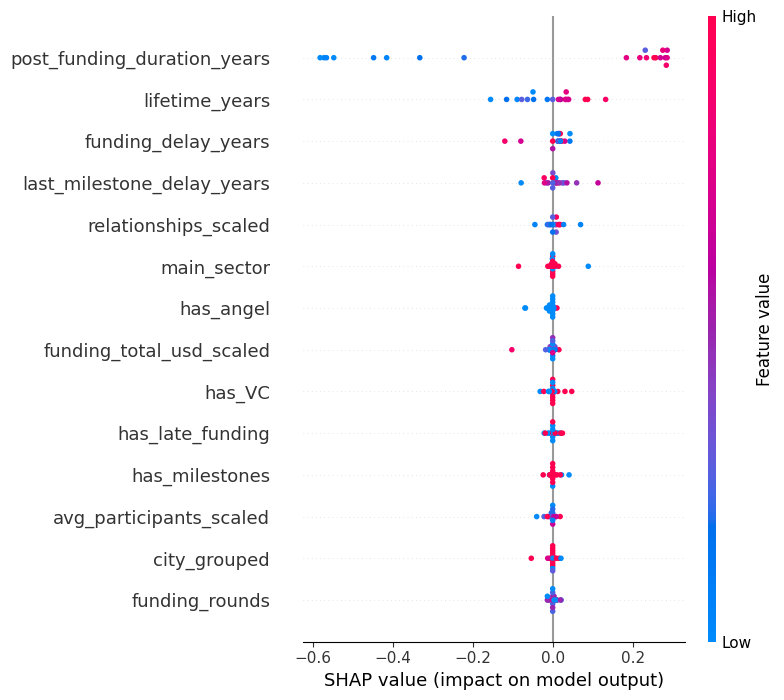

In [31]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt
import numpy as np

# ======================
# 1. codificación de categóricas y división en numpy arrays
# ======================
df_tabnet = df.copy()
cat_cols = df_tabnet.select_dtypes(include=['object', 'bool', 'category']).columns
for col in cat_cols:
    df_tabnet[col] = LabelEncoder().fit_transform(df_tabnet[col])

feature_names = df_tabnet.drop(columns='labels').columns.tolist()
X_array = df_tabnet.drop(columns='labels').values
y_array = df_tabnet['labels'].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X_array, y_array,
    test_size=0.2,
    stratify=y_array,
    random_state=42
)

# ======================
# 2. definición del modelo con verbose para mostrar evolución
# ======================
base_model = TabNetClassifier(
    seed=42,
    verbose=1,
    output_dim=2
)

# ======================
# 3. grid de hiperparámetros acotado
# ======================
param_grid = {
    'n_d':             [8, 16],
    'n_a':             [8, 16],
    'n_steps':         [3],
    'gamma':           [1.3],
    'optimizer_params':[{'lr': 2e-2}]
}

# ======================
# 4. validación cruzada estratificada reducida
# ======================
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ======================
# 5. scorer manual para AUC usando predict_proba
# ======================
def auc_score(estimator, X, y):
    y_proba = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_proba)

# ======================
# 6. configuración de RandomizedSearchCV
# ======================
search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=4,
    cv=cv,
    scoring=auc_score,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    error_score='raise'
)

# ======================
# 7. parámetros de fit para TabNet (early stopping y métricas)
# ======================
fit_params = {
    'max_epochs':         100,
    'patience':           10,
    'batch_size':         128,
    'virtual_batch_size': 64,
    'eval_set':           [(X_test, y_test)],
    'eval_name':          ['val'],
    'eval_metric':        ['accuracy','auc']
}

# ======================
# 8. ejecución de la búsqueda
# ======================
search.fit(X_train, y_train, **fit_params)
print("mejores parámetros según AUC:", search.best_params_)
best_tabnet = search.best_estimator_

# ======================
# 9. evaluación final sobre test
# ======================
y_pred  = best_tabnet.predict(X_test)
y_proba = best_tabnet.predict_proba(X_test)[:, 1]

print(f"accuracy en test: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, digits=4))
print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

# ======================
# 10. curva ROC
# ======================
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5), dpi=120)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.4f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("curva ROC – TabNet optimizado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ======================
# 11. explicación con SHAP usando nombres reales de features
# ======================
rng         = np.random.RandomState(42)
bg_idx      = rng.choice(X_train.shape[0], 50, replace=False)
exp_idx     = rng.choice(X_test.shape[0], 20, replace=False)
X_background= X_train[bg_idx]
X_explain   = X_test[exp_idx]

predict_fn  = lambda x: best_tabnet.predict_proba(x)
explainer   = shap.KernelExplainer(predict_fn, X_background)
shap_values = explainer.shap_values(X_explain, nsamples=50)

if isinstance(shap_values, list) and len(shap_values) > 1:
    shap_vals_pos = shap_values[1]
else:
    shap_vals_pos = shap_values

expl = shap.Explanation(
    values       = shap_vals_pos,
    base_values  = np.repeat(explainer.expected_value[1], X_explain.shape[0]),
    data         = X_explain,
    feature_names= feature_names
)

if expl.values.ndim == 3:
    vals = expl.values[:, :, 1]
else:
    vals = expl.values
vals = vals.reshape(expl.data.shape)

shap.initjs()
shap.summary_plot(vals, expl.data, feature_names=expl.feature_names)